# Uplift? Or Forecasting Randomized Data

This notebook is my solution and review the SHIFT CFT 2022 Kaggle problem.

In the data we have information about one retail's chain clients - who received a text (SMS) and who didn't. This is called a treatment flag. This treatment as we understand is a completely random occurrence.

We also have purchased / not purchased flag, thus we can track clients who were treated and purchased something and vice-versa.


**Target** now the target is formulated as follows:
   - 1 if:
        - (treated==1) and (purchased==1) or
        - (treated==0) and (purchased==0)
   - 0 otherwise

They also ask that the target is projecting who needs to recieve a text for presuasion to purchase, i.e. uplift.

But we can see that this is not the case and we are actually asked to predict a randomized data.

$$ 
Target = P(treatment) * P(purchase) + P(notreatment)*P(nopurchase)
$$


And so the target actually depends on a randomized variable - treatment. As we believe the treatment sample to make the experiment was randomized by the design, which is a sensible thought in A-B testing. 


Nevertheless, the data has some information about the treatment and purchase/no purchase, which allows us to predict the outcome even though with very limited accuracy (top submissions on Kaggle are around .05 in Gini criterion).

**Uplift** - is calculated as difference in target('purchased') mean between treated and control groups by the design of this competition. This makes sense when we have (as in our case) a large amount of data and relatively balanced treatment and control groups.

We will do a **two-model approach**:
* Data is split by two - treatment group and control group
* Two independent classifiers are built
* Each one makes a predictions on the full dataset
* Substracting probabilities from one to another we get an estimated **uplift** effect

**What do we do?**

1. Analyse the data and see if there are any insights
2. Construct some helpful features
3. Two-model approach to estimate the effect
4. Predict the ranking for Gini / ROC-AUC criterion by taking differences in probabilities in two-model approach.


**Summary of results:**

* Two-model predictions gives a better understanding which of the clients are much likely to purchase under the treatment
* Two-model approach helped us to calculate the uplift effect on the train data which we estimated around 3.16%, which is quite close to the difference of the means approach which gives 3.35%
* The best solution was able to predict about 3% above the baseline (random predictor). Which also kind of points to the issue of the target definition.



## Opening data

In [1]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import catboost

from pandas_profiling import ProfileReport
from scipy import integrate, special, stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

In [2]:
baseline = pd.read_csv('baseline.csv')
products = pd.read_csv('x5-uplift-valid/data/products.csv')
test = pd.read_csv('x5-uplift-valid/data/test.csv')
train = pd.read_csv('x5-uplift-valid/data/train.csv')
clients2 = pd.read_csv('x5-uplift-valid/data/clients2.csv')
train_purch = pd.read_csv('x5-uplift-valid/train_purch/train_purch.csv')
test_purch = pd.read_csv('x5-uplift-valid/test_purch/test_purch.csv')

## EDA

### Products

### Filling NA values and outliers

In [3]:
#segment_id fill with the most popular segment for level1-4 segment

for i in reversed(range(1,5)):
    val_counts =  products.loc[~(products.segment_id.isna()), ['level_'+str(i), 'segment_id']].groupby('level_'+str(i)).agg(pd.Series.mode)
    for lev in val_counts.index:
        products.loc[(products.segment_id.isna()) & (products['level_'+str(i)] == lev), 'segment_id'] = val_counts.loc[lev].segment_id

#same for brand_id - filling it with the most popular for given level

for i in reversed(range(1,5)):
    val_counts =  products.loc[~(products.brand_id.isna()), ['level_'+str(i), 'brand_id']].groupby('level_'+str(i)).agg(pd.Series.mode)
    for lev in val_counts.index:
        products.loc[(products.brand_id.isna()) & (products['level_'+str(i)] == lev), 'brand_id'] = val_counts.loc[lev].brand_id[0]

#dropping any leftovers
products.dropna(inplace=True)

#changing dtype
products.segment_id = products.segment_id.astype('object')

In [4]:
products.loc[products.is_alcohol == 1].segment_id.value_counts()

321.0    847
190.0    643
117.0    247
165.0    243
218.0    153
136.0    100
61.0      59
174.0     44
186.0     34
240.0     21
Name: segment_id, dtype: int64

* We can see the structure of the products - ranging from `level_1`  to `level_4` in an increasing variety of products
* Segment_id - could be a pricing segment
* Netto is the weight of the product
* There are about 10% zeros in brand_id, could be an error in data
* Products are very segregated, for examples `is_alcohol` has unique level 2 value and also has only about 10 values in segment_id

### Train

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140027 entries, 0 to 140026
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   client_id      140027 non-null  object
 1   treatment_flg  140027 non-null  int64 
 2   purchased      140027 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


In [6]:
train.head()

,client_id,treatment_flg,purchased
0,ad6561e2d8,1,1
1,7c1ccbf93f,1,1
2,b58fadcab6,1,1
3,e99e6fabb9,0,0
4,27fb6f8520,1,1


* Adding column `target`:
    - 1 if client made purchase after treatment or client didn't make a purchase if no treatment
    - 0 otherwise 


In [7]:
train['target'] = 0
train.loc[(train.treatment_flg == train.purchased), 'target'] = 1
train.mean()

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\2561822998.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.mean()


treatment_flg    0.500325
purchased        0.619630
target           0.516850
dtype: float64

* We see that the data is fairly balanced - about 62% in purchased but in the target and treatment_flg it is 50/50. That's why the baseline submission basically uniform distribution with .5 probability.

### Clients

In [8]:
clients2.drop('client_id.1', axis=1, inplace=True)
#converting to date_time
clients2.first_issue_date = pd.to_datetime(clients2.first_issue_date)
clients2.first_redeem_date = pd.to_datetime(clients2.first_redeem_date)

#max time as per transaction dataset
max_date = pd.Timestamp('2019-03-18 23:19:28')
clients2.loc[clients2.first_redeem_date > pd.to_datetime('2019-03-18 23:19:28'), 'first_redeem_date'] = pd.to_datetime('2019-03-18 23:19:28')


#There are outliers in gender - we will clip them to 0.3% quantile
clients2.age.clip(lower=clients2.age.quantile(.003), upper=clients2.age.quantile(.997), inplace=True)


* We assume that the data holds clients' ids, first issue date - date of the issue of loyalty card and reedem date - firs time that client using the loyalty card
* There are outliers in gender - we will clip them to 1% quantile
* To clients2 dataframe we can add:
    * One-hot-encoding for gender ('U' for unknown is left out)
    * Was the card redeemed? If it wasn't redeemed we take max out of first_redeem_date
    * Days since issue and redeem

### Purchased

* `trn_sum_from_iss` - how much cash was spent on product with cash
* `trn_sum_from_red` - how much was spent cash+points if points were spent
* `purchase_sum` - total sum of purchased products for transaction id
* Time period for which data is taken is between '2018-11-21' and '2019-03-18' (approx 117 days)

In [9]:
train_purch.transaction_datetime = pd.to_datetime(train_purch.transaction_datetime)
test_purch.transaction_datetime = pd.to_datetime(test_purch.transaction_datetime)
print((train_purch.transaction_datetime.max(), train_purch.transaction_datetime.min()))
print((test_purch.transaction_datetime.max(),test_purch.transaction_datetime.min()))

(Timestamp('2019-03-18 23:19:28'), Timestamp('2018-11-21 21:02:33'))
(Timestamp('2019-03-18 22:08:09'), Timestamp('2018-11-21 21:02:51'))


In [10]:
train_purch['cash_spent_product'] = train_purch['trn_sum_from_iss']
train_purch['trn_sum_from_red'].fillna(0, inplace=True)
train_purch['points_spent_product'] = 0
train_purch.loc[train_purch['trn_sum_from_red']>0, 'points_spent_product'] = train_purch['trn_sum_from_red'] - train_purch['trn_sum_from_iss']
train_purch['price_product'] = train_purch['points_spent_product'] + train_purch['cash_spent_product']

test_purch['cash_spent_product'] = test_purch['trn_sum_from_iss']
test_purch['trn_sum_from_red'].fillna(0, inplace=True)
test_purch['points_spent_product'] = 0
test_purch.loc[test_purch['trn_sum_from_red']>0, 'points_spent_product'] = test_purch['trn_sum_from_red'] - test_purch['trn_sum_from_iss']
test_purch['price_product'] = test_purch['points_spent_product'] + test_purch['cash_spent_product']

### Discounts and loyalty points

* In the data we have different loyalty points:
    * regular_points_received
    * express_points_received
    * regular_points_spent
    * express_points_spent
* Regular points usually go as 1/100 for each rouble spent. They have annual time limit.
* Expess points are loyalty points that given randomly. The exact mechanics of attibuting these points is not unknown but they pursuade inactive cutstomers to go for a purchase. They usually have a shorter period to be spent - like a week or so.
* It is worth looking closely at loyalty points as they could be an indicator of 'purchase' or 'treatment'

In [11]:
train_temp = train_purch.copy()
train_temp['date'] = train_temp['transaction_datetime'].dt.date

In [12]:
train_temp  = train_temp.groupby(['transaction_id', 'date', 'client_id'])[['purchase_sum', 'regular_points_received', 'express_points_received',
       'regular_points_spent', 'express_points_spent']].agg('mean')
train_temp.reset_index(level=[0,1,2], inplace=True)

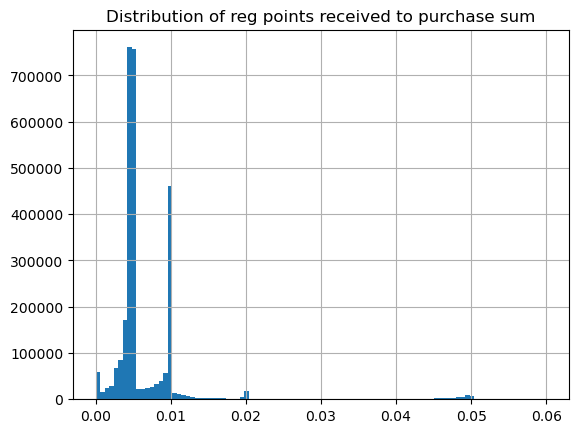

In [13]:
train_temp['reg_points_to_p_sum'] = train_temp['regular_points_received'] / train_temp['purchase_sum']
train_temp['reg_points_to_p_sum'].hist(bins=100, range=(0,0.06))
plt.title('Distribution of reg points received to purchase sum')
plt.show()

* We see clear peaks here in the distribution:
    * Looks like usually it is 1% or .5% of points recieved of pruchase sum
    * Rarely more than that - like 2% or 5% of purchase

In [14]:
(train_temp['express_points_received']>0).sum() / train_temp.shape[0]

0.0009367679834941268

* Express points don't usually come with the purchases - only in 0.9% cases
* Could be an indicator (express points received - yes or no) to be added

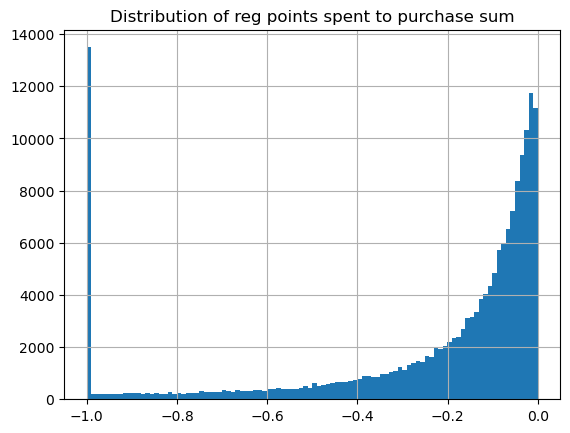

In [15]:
train_temp['reg_points_spent_ratio'] = train_temp['regular_points_spent'] / train_temp['purchase_sum']
train_temp['reg_points_spent_ratio'].hist(bins=100, range=(-1, -0.001))
plt.title('Distribution of reg points spent to purchase sum')
plt.show()

* If there is no limit - people can cover as much as 100% of purchase sum - we see a peak there at -1

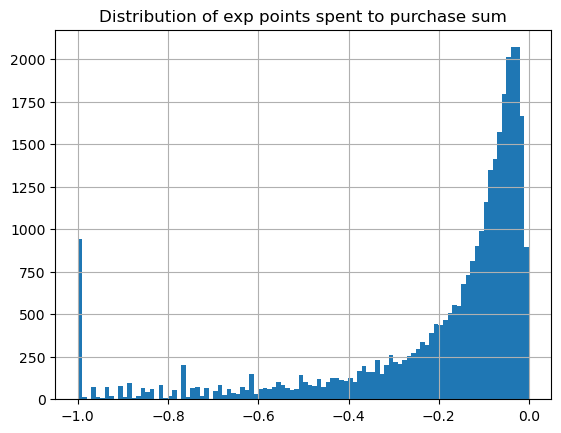

In [16]:
train_temp['exp_points_spent_ratio'] = train_temp['express_points_spent'] / train_temp['purchase_sum']
train_temp['exp_points_spent_ratio'].hist(bins=100, range=(-1, -0.001))
plt.title('Distribution of exp points spent to purchase sum')
plt.show()

* We see the distribution is very similar to reg points spent with much less of a peak at 100%

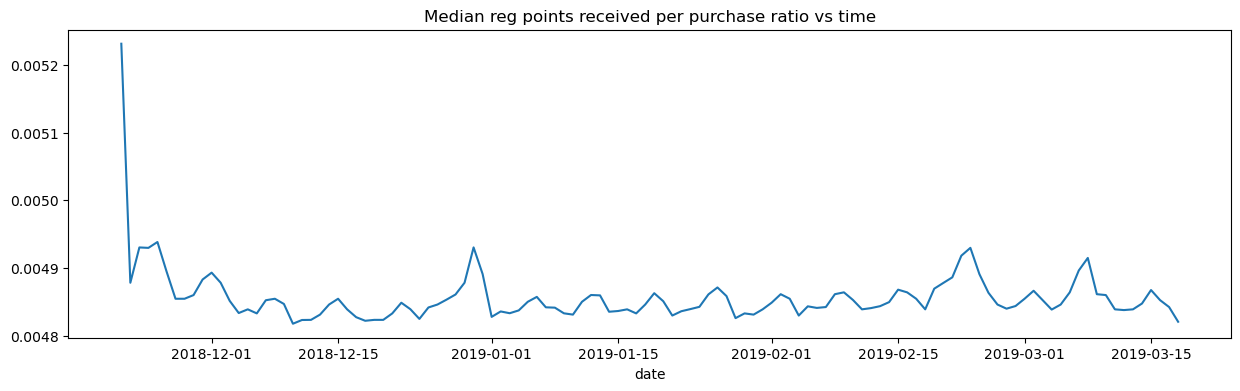

In [17]:
df_ts = train_temp.groupby('date').reg_points_to_p_sum.median()

ax = df_ts.plot(x=df_ts.index, figsize=(15,4))

plt.title('Median reg points received per purchase ratio vs time')
plt.show()

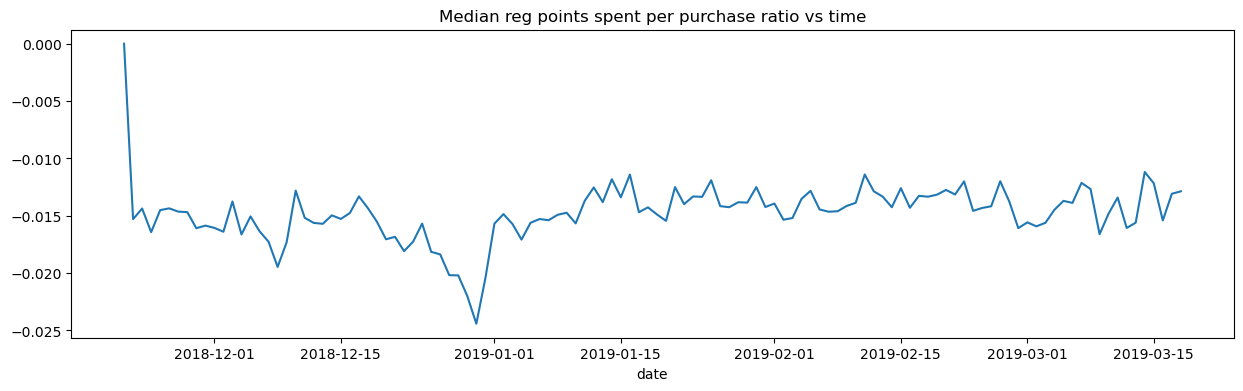

In [18]:
df_ts = train_temp.groupby('date').reg_points_spent_ratio.mean()

ax = df_ts.plot(x=df_ts.index, figsize=(15,4))

plt.title('Median reg points spent per purchase ratio vs time')
plt.show()

* We see a peak here at 31-Dec as people dump all of their points as they are getting zeroed in the next year

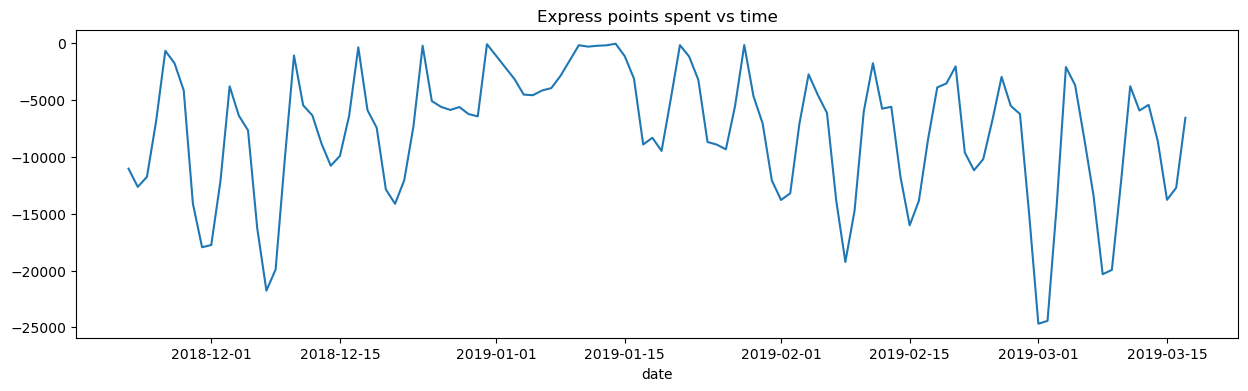

In [19]:
df_ts = train_temp.loc[train_temp.express_points_spent<0].groupby('date').express_points_spent.sum()

ax = df_ts.plot(x=df_ts.index, figsize=(15,4))

plt.title('Express points spent vs time')
plt.show()

,sum,count
sum,1.000000,-0.055911
count,-0.055911,1.000000


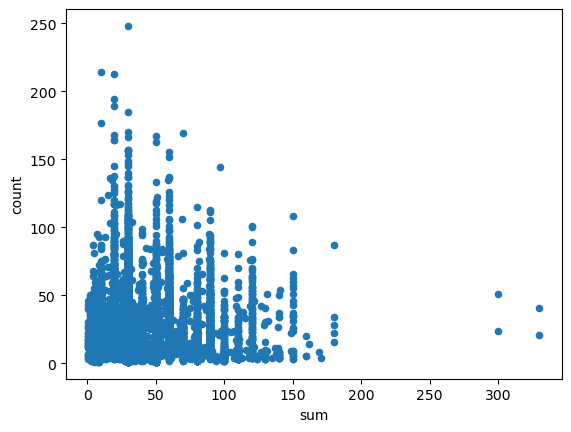

In [20]:
temp_ = train_temp.groupby('client_id')['express_points_spent'].agg(['sum', 'count'])
temp_['sum'] = - temp_['sum']
temp_.loc[temp_['sum']>0].plot(x='sum', y='count', kind='scatter')
temp_.loc[temp_['sum']>0].corr()

* We can see a negative relationship (even though correlation is quite small) between express points spent and number of transactions. 
* Thus, it confirms the approach those who make infrequent stops at the stores recieve more express points
* What's also interesting the date is seggregated by 10th, probably due to the rounding

### Merging

In [21]:
train_purch = pd.merge(left=train_purch, right=products, left_on='product_id', right_on='product_id')
test_purch = pd.merge(left=test_purch, right=products, left_on='product_id', right_on='product_id')

## Feature engineering

**New features from clients dataset**

In [22]:
#OHA
clients2 = pd.get_dummies(data=clients2, columns=['gender'])
clients2.drop('gender_U', inplace=True, axis=1)
clients2['redeemed'] = 0
clients2.loc[~(clients2.first_redeem_date.isna()), 'redeemed'] = 1
clients2.first_redeem_date.fillna(value='2022-1-1', inplace=True)

#how many days past issue (how long ago was it issued)
clients2['days_since_issue'] = (max_date - clients2['first_issue_date']).dt.days

#days since issue >100
clients2['since_issue_more_100'] = 0
clients2.loc[clients2.days_since_issue > 100, 'since_issue_more_100'] = 1

#how many days between issue and redeem
clients2['days_issue_redeem'] = (clients2['first_redeem_date'] - clients2['first_issue_date']).dt.days

#days between redeem and issue > 750
clients2['issue_redeem_more_750'] = 0
clients2.loc[clients2.days_issue_redeem > 750, 'issue_redeem_more_750'] = 1

#how many days since redeem
clients2['days_since_redeem'] = (max_date - clients2['first_redeem_date']).dt.days

#days since redeem >50
clients2['since_redeem_more_50'] = 0
clients2.loc[clients2.days_since_redeem > 50, 'since_redeem_more_50'] = 1

#age more than 50
clients2['age_more_50'] = 0
clients2.loc[clients2.age >50, 'age_more_50'] = 1

In [23]:
def make_features_clients(clients, clients2):
    features_columns = ['client_id', 'age', 'gender_F',
       'gender_M', 'redeemed', 'days_since_issue', 'since_issue_more_100',
       'days_issue_redeem', 'issue_redeem_more_750', 'days_since_redeem',
       'since_redeem_more_50', 'age_more_50']
    temp_ = pd.merge(left=clients, right=clients2, left_on='client_id', right_on='client_id')
    return temp_.loc[:,features_columns]

In [24]:
train_1 = make_features_clients(train, clients2)
train_1.set_index(train_1['client_id'], drop=True, inplace=True)
train_1

,client_id,age,gender_F,gender_M,redeemed,days_since_issue,since_issue_more_100,days_issue_redeem,issue_redeem_more_750,days_since_redeem,since_redeem_more_50,age_more_50
client_id,,,,,,,,,,,,
ad6561e2d8,ad6561e2d8,50.0,1,0,1,470,1,171,0,299,1,0
7c1ccbf93f,7c1ccbf93f,24.0,1,0,1,493,1,104,0,389,1,0
b58fadcab6,b58fadcab6,36.0,0,0,1,501,1,316,0,184,1,0
e99e6fabb9,e99e6fabb9,79.0,1,0,1,306,1,14,0,292,1,1
27fb6f8520,27fb6f8520,34.0,1,0,1,609,1,150,0,458,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
999d284453,999d284453,72.0,0,0,1,138,1,138,0,0,0,1
f634deea4e,f634deea4e,35.0,0,0,1,407,1,36,0,371,1,0
16cb4f99b0,16cb4f99b0,50.0,1,0,1,388,1,388,0,0,0,0


In [25]:
time_periods ={
    'first_month': ['2018-11-21','2018-12-21'],
    'one_week': ['2019-03-10','2019-03-19'],
    'two_weeks': ['2019-03-04','2019-03-19'],
    'one_month': ['2019-02-18','2019-03-19'],
    'two_months': ['2019-01-18','2019-03-19'],
    'total': ['2018-11-21','2019-03-19']
    }

In [26]:
def make_stats(df, time_periods):
    stats = {}
    for period in time_periods:
            
     
            #making the slice for a specific time period
            start = time_periods[period][0]
            end = time_periods[period][1]
            X = df.loc[(df.transaction_datetime >= start) & (df.transaction_datetime <= end),:]
            
            #median days from last transaction
            stats['total'+'_median_days_from_last_transaction'] = (X.transaction_datetime.max() - X.groupby('client_id').transaction_datetime.max()).dt.days.median()
            
            #median number of items bought
            stats[period +'_median_n_items'] = X.groupby('client_id').transaction_id.count().median()
            
            #median number of transactions
            stats[period +'_median_n_transactions'] = X.groupby('client_id').transaction_id.nunique().median()
            
            #median number of items per transaction
            stats[period +'_median_n_items_transaction'] = (X.groupby('client_id').transaction_id.count() / X.groupby('client_id').transaction_id.nunique()).median()
            
            #median of median regular points received
            stats[period +'_median_r_points'] = ((X.groupby(['client_id', 'transaction_id']).regular_points_received.mean()).groupby('client_id').median()).median()
            
            #median of median express points received
            stats[period +'_median_e_received_points'] = ((X.groupby(['client_id', 'transaction_id']).express_points_received.mean()).groupby('client_id').median()).mean()
            
            #mean of median r points spent
            stats[period +'_median_r_points_spent'] = (X.groupby(['client_id', 'transaction_id']).regular_points_spent.mean()).groupby('client_id').median().mean()
            
            #mean of median e points spent
            stats[period +'_median_e_points_spent'] = (X.groupby(['client_id', 'transaction_id']).express_points_spent.mean()).groupby('client_id').median().mean()
            
            #median purchase sum
            stats[period +'_median_purchase_sum'] = (X.groupby(['client_id', 'transaction_id']).purchase_sum.mean()).groupby('client_id').median().median()
            
            #top 10 most popular products
            temp = X.value_counts('product_id').index
            for i in range(10):
                stats[period +'_most_popular_product_'+str(i)] = temp[i]
                
            #top 10 most popular own label products 
            temp = X.loc[X.is_own_trademark==1].value_counts('product_id').index
            for i in range(10):
                stats[period+'_most_popular_own_product_'+str(i)] = temp[i]
                
            #top 10 most frequent stores
            temp = X.groupby('store_id').transaction_id.nunique().sort_values(ascending=False).index
            for i in range(10):
                stats[period+'_most_popular_store_'+str(i)] = temp[i]
                
            #most popular level 1
            stats[period+'_most_popular_level_1'] = X.value_counts('level_1').idxmax()
            
            #top 10 most pop level 2
            temp = X.value_counts('level_2').index
            for i in range(10):
                stats[period+'_most_popular_level_2_'+str(i)] = temp[i]
                
            #top 10 most pop level 3
            temp = X.value_counts('level_3').index
            for i in range(10):
                stats[period+'_most_popular_level_3_'+str(i)] = temp[i]
                
            #top 10 most pop level 4
            temp = X.value_counts('level_4').index
            for i in range(10):
                stats[period+'_most_popular_level_4_'+str(i)] = temp[i] 
            
            #top 10 most pop segment_id
            temp = X.value_counts('segment_id').index
            for i in range(10):
                stats[period+'_most_popular_segment_id_'+str(i)] = temp[i]
            
            #top 10 most pop brand_id
            temp = X.value_counts('brand_id').index
            for i in range(10):
                stats[period+'_most_popular_brand_id_'+str(i)] = temp[i]
                
            #top 10 most pop vendor_id
            temp = X.value_counts('vendor_id').index
            for i in range(10):
                stats[period+'_most_popular_vendor_id_'+str(i)] = temp[i]
    return stats

### Making features from loyalty data

In [27]:
def make_temp_df(df):
    temp = df.copy()
    temp['transaction_datetime'] = pd.to_datetime(temp['transaction_datetime'])
    temp['date'] = temp['transaction_datetime'].dt.date
    temp = temp.groupby(['transaction_id', 'date', 'client_id'])[['purchase_sum', 'regular_points_received', 'express_points_received',
       'regular_points_spent', 'express_points_spent']].agg('mean')
    temp.reset_index(level=[0,1,2], inplace=True)
    
    temp['date'] = pd.to_datetime(temp['date'])
    temp['dec_31_purch'] = (temp.date == '2018-12-31')
    temp['dec_30_purch'] = temp.date == '2018-12-30'
    temp['feb_23_purch'] = temp.date == '2019-02-23'
    temp['mar_8_purch'] = temp.date == '2019-03-08'
    
    temp['reg_points_received_ratio'] = temp['regular_points_received'] / temp['purchase_sum']
    temp['reg_points_received_ratio_more_05'] = temp['reg_points_received_ratio'] > .0048
    temp['reg_points_received_ratio_more_1'] = temp['reg_points_received_ratio'] > .009
    
    temp['reg_points_spent_ratio'] = temp['regular_points_spent'] / temp['purchase_sum']
    
    temp['reg_points_spent_ratio_equal_1'] = temp['reg_points_spent_ratio'] < -0.98
    
    temp['exp_points_received_indicator'] = temp['express_points_received'] > 0
    
    temp['exp_points_spent_indicator'] = temp['express_points_spent'] < 0
    
    temp['exp_points_spent_ratio'] = temp['express_points_spent'] / temp['purchase_sum']
    
    temp['exp_points_spent_ratio_equal_1'] = temp['exp_points_spent_ratio'] < -0.98
    
    
    return temp

In [28]:
def make_features_loyalty(clients, df, time_periods):
    
    for period in time_periods:
        
        #making slice given period
        start = time_periods[period][0]
        end = time_periods[period][1]

        X = df.loc[(df.transaction_datetime >= start) & (df.transaction_datetime <= end),:]
        
        X = make_temp_df(X)

        #days from last transaction
        clients['total'+'_days_from_last_transaction'] = (X.date.max() - X.groupby('client_id').date.max()).dt.days

        #days from last transaction > 10
        clients['total'+'_days_transaction_more_10'] = (clients['total'+'_days_from_last_transaction'] > 10).astype(int)

        #days from last transaction > 5
        clients['total'+'_days_transaction_more_5'] = (clients['total'+'_days_from_last_transaction'] > 5).astype(int)
        
        #number of transactions
        clients[period+'_n_transactions'] = X.groupby('client_id').transaction_id.nunique()
        

        #regular_points_received_total
        clients[period+'_regular_points_received_total'] = X.groupby(['client_id']).regular_points_received.sum()

        #regular_points_received average per transaction
        clients[period+'_regular_points_received_average_per_transaction'] = clients[period+'_regular_points_received_total'] / clients[period+'_n_transactions']
        
        #regular_points_received ratio median
        clients[period+'_regular_points_received_ratio_median'] = X.groupby(['client_id']).reg_points_received_ratio.median()
        
        #number of regular_points_received ratio > .5%
        clients[period+'_regular_points_received_ratio_more_05'] = X.groupby(['client_id']).reg_points_received_ratio_more_05.sum()
        
        #number of regular_points_received ratio > 1%
        clients[period+'_regular_points_received_ratio_more_1'] = X.groupby(['client_id']).reg_points_received_ratio_more_1.sum()
        
        
        #express_points_received_total
        clients[period+'_n_exp_points_received_total'] = X.groupby(['client_id']).express_points_received.sum()

        #number of transaction where express_points_received
        clients[period+'_exp_points_received_total'] = X.groupby(['client_id']).exp_points_received_indicator.sum()
        
        #express_points_received_average per transaction
        clients[period+'_exp_points_received_average'] = clients[period+'_exp_points_received_total'] / clients[period+'_n_transactions']
        
        
        #regular_points_spent_total
        clients[period+'_regular_points_spent_total'] = X.groupby(['client_id']).regular_points_spent.sum()
        
        #regular_points_spent average per transaction
        clients[period+'_regular_points_spent_total_average'] = clients[period+'_regular_points_spent_total'] / clients[period+'_n_transactions']
        
        #regular_points_spent ratio mean
        clients[period+'_regular_points_spent_ratio_mean'] = X.groupby(['client_id']).reg_points_spent_ratio.mean()
        
        #number of regular_points_spent ratio = 1
        clients[period+'_regular_points_spent_ratio_equal_1'] = X.groupby(['client_id']).reg_points_spent_ratio_equal_1.sum()
        
        
        #express_points_spent_total
        clients[period+'_exp_points_spent_total'] = X.groupby(['client_id']).express_points_spent.sum()
        
        #number of transaction where express_points_spent
        clients[period+'_n_exp_points_spent_total'] = X.groupby(['client_id']).exp_points_spent_indicator.sum()
        
        #express_points_spent_average
        clients[period+'_exp_points_average'] = clients[period+'_exp_points_spent_total'] / clients[period+'_n_transactions']

        # express_points_spent ratio mean
        clients[period+'_exp_points_spent_ratio_mean'] = X.groupby(['client_id']).exp_points_spent_ratio.mean()
        
        #number of express_points_spent ratio = 1
        clients[period+'_express_points_spent_ratio_equal_1'] = X.groupby(['client_id']).exp_points_spent_ratio_equal_1.sum()
        
        
        #purchase sum total
        clients[period+'_purchase_sum_total'] = X.groupby(['client_id']).purchase_sum.sum()

        #purchase sum median
        clients[period+'_purchase_sum_median'] = X.groupby(['client_id']).purchase_sum.median()
        
        #purchase sum max
        clients[period+'_purchase_sum_max'] = X.groupby(['client_id']).purchase_sum.max()
        
        #number of purchases on 30 dec
        clients[period+'_dec_30_purch'] = X.groupby(['client_id'])['dec_30_purch'].sum()
        
        #number of purchases on 30 dec
        clients[period+'_dec_31_purch'] = X.groupby(['client_id'])['dec_31_purch'].sum()
    
        #number of purchases on 23 FEB
        clients[period+'_feb_23_purch'] = X.groupby(['client_id'])['feb_23_purch'].sum()
        
        #number of purchases on 8 MAR
        clients[period+'_mar_8_purch'] = X.groupby(['client_id'])['mar_8_purch'].sum()
        
                                                                

In [29]:
%%time
#making new features
make_features_loyalty(train_1, train_purch, time_periods)
train_2 = train_1.copy()
train_2.fillna(0, inplace=True)
train_2

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_purchase_sum_total'] = X.groupby(['client_id']).purchase_sum.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_purchase_sum_median'] = X.groupby(['client_id']).purchase_sum.median()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is us

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_regular_points_spent_ratio_equal_1'] = X.groupby(['client_id']).reg_points_spent_ratio_equal_1.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_exp_points_spent_total'] = X.groupby(['client_id']).express_points_spent.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:69: PerformanceWarning: D

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_n_exp_points_received_total'] = X.groupby(['client_id']).express_points_received.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_exp_points_received_total'] = X.groupby(['client_id']).exp_points_received_indicator.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:49: PerformanceWarning: Dat

Wall time: 5min


,client_id,age,gender_F,gender_M,redeemed,days_since_issue,since_issue_more_100,days_issue_redeem,issue_redeem_more_750,days_since_redeem,since_redeem_more_50,age_more_50,total_days_from_last_transaction,total_days_transaction_more_10,total_days_transaction_more_5,first_month_n_transactions,first_month_regular_points_received_total,first_month_regular_points_received_average_per_transaction,first_month_regular_points_received_ratio_median,first_month_regular_points_received_ratio_more_05,first_month_regular_points_received_ratio_more_1,first_month_n_exp_points_received_total,first_month_exp_points_received_total,first_month_exp_points_received_average,first_month_regular_points_spent_total,first_month_regular_points_spent_total_average,first_month_regular_points_spent_ratio_mean,first_month_regular_points_spent_ratio_equal_1,first_month_exp_points_spent_total,first_month_n_exp_points_spent_total,first_month_exp_points_average,first_month_exp_points_spent_ratio_mean,first_month_express_points_spent_ratio_equal_1,first_month_purchase_sum_total,first_month_purchase_sum_median,first_month_purchase_sum_max,first_month_dec_30_purch,first_month_dec_31_purch,first_month_feb_23_purch,first_month_mar_8_purch,one_week_n_transactions,one_week_regular_points_received_total,one_week_regular_points_received_average_per_transaction,one_week_regular_points_received_ratio_median,one_week_regular_points_received_ratio_more_05,one_week_regular_points_received_ratio_more_1,one_week_n_exp_points_received_total,one_week_exp_points_received_total,one_week_exp_points_received_average,one_week_regular_points_spent_total,one_week_regular_points_spent_total_average,one_week_regular_points_spent_ratio_mean,one_week_regular_points_spent_ratio_equal_1,one_week_exp_points_spent_total,one_week_n_exp_points_spent_total,one_week_exp_points_average,one_week_exp_points_spent_ratio_mean,one_week_express_points_spent_ratio_equal_1,one_week_purchase_sum_total,one_week_purchase_sum_median,one_week_purchase_sum_max,one_week_dec_30_purch,one_week_dec_31_purch,one_week_feb_23_purch,one_week_mar_8_purch,two_weeks_n_transactions,two_weeks_regular_points_received_total,two_weeks_regular_points_received_average_per_transaction,two_weeks_regular_points_received_ratio_median,two_weeks_regular_points_received_ratio_more_05,two_weeks_regular_points_received_ratio_more_1,two_weeks_n_exp_points_received_total,two_weeks_exp_points_received_total,two_weeks_exp_points_received_average,two_weeks_regular_points_spent_total,two_weeks_regular_points_spent_total_average,two_weeks_regular_points_spent_ratio_mean,two_weeks_regular_points_spent_ratio_equal_1,two_weeks_exp_points_spent_total,two_weeks_n_exp_points_spent_total,two_weeks_exp_points_average,two_weeks_exp_points_spent_ratio_mean,two_weeks_express_points_spent_ratio_equal_1,two_weeks_purchase_sum_total,two_weeks_purchase_sum_median,two_weeks_purchase_sum_max,two_weeks_dec_30_purch,two_weeks_dec_31_purch,two_weeks_feb_23_purch,two_weeks_mar_8_purch,one_month_n_transactions,one_month_regular_points_received_total,one_month_regular_points_received_average_per_transaction,one_month_regular_points_received_ratio_median,one_month_regular_points_received_ratio_more_05,one_month_regular_points_received_ratio_more_1,one_month_n_exp_points_received_total,one_month_exp_points_received_total,one_month_exp_points_received_average,one_month_regular_points_spent_total,one_month_regular_points_spent_total_average,one_month_regular_points_spent_ratio_mean,one_month_regular_points_spent_ratio_equal_1,one_month_exp_points_spent_total,one_month_n_exp_points_spent_total,one_month_exp_points_average,one_month_exp_points_spent_ratio_mean,one_month_express_points_spent_ratio_equal_1,one_month_purchase_sum_total,one_month_purchase_sum_median,one_month_purchase_sum_max,one_month_dec_30_purch,one_month_dec_31_purch,one_month_feb_23_purch,one_month_mar_8_purch,two_months_n_transactions,two_months_regular_points_received_total,two_months_regular_points_recei

## Test features construction

In [30]:
test_2 = make_features_clients(test, clients2)
test_2.set_index(test_2['client_id'], drop=True, inplace=True)
test_2

,client_id,age,gender_F,gender_M,redeemed,days_since_issue,since_issue_more_100,days_issue_redeem,issue_redeem_more_750,days_since_redeem,since_redeem_more_50,age_more_50
client_id,,,,,,,,,,,,
a9a604ed6e,a9a604ed6e,36.0,1,0,0,186,1,1205,1,-1020,0,0
ebd7360016,ebd7360016,63.0,1,0,1,623,1,59,0,563,1,1
908cd9b8e8,908cd9b8e8,49.0,1,0,1,353,1,105,0,248,1,0
dceb8ce861,dceb8ce861,46.0,0,0,1,528,1,309,0,219,1,0
f4f0ac6b06,f4f0ac6b06,89.0,0,0,1,264,1,232,0,31,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4762fb04c5,4762fb04c5,26.0,0,1,1,291,1,208,0,82,1,0
533d1516e7,533d1516e7,37.0,0,1,1,535,1,100,0,435,1,0
c93b21a707,c93b21a707,42.0,0,0,1,166,1,166,0,0,0,0


In [31]:
%%time
#making new features
make_features_loyalty(test_2, test_purch, time_periods)
test_2.fillna(0, inplace=True)
test_2

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_purchase_sum_total'] = X.groupby(['client_id']).purchase_sum.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_purchase_sum_median'] = X.groupby(['client_id']).purchase_sum.median()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is us

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_regular_points_spent_ratio_equal_1'] = X.groupby(['client_id']).reg_points_spent_ratio_equal_1.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_exp_points_spent_total'] = X.groupby(['client_id']).express_points_spent.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:69: PerformanceWarning: D

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_n_exp_points_received_total'] = X.groupby(['client_id']).express_points_received.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clients[period+'_exp_points_received_total'] = X.groupby(['client_id']).exp_points_received_indicator.sum()
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_6284\4214889803.py:49: PerformanceWarning: Dat

Wall time: 2min 8s


,client_id,age,gender_F,gender_M,redeemed,days_since_issue,since_issue_more_100,days_issue_redeem,issue_redeem_more_750,days_since_redeem,since_redeem_more_50,age_more_50,total_days_from_last_transaction,total_days_transaction_more_10,total_days_transaction_more_5,first_month_n_transactions,first_month_regular_points_received_total,first_month_regular_points_received_average_per_transaction,first_month_regular_points_received_ratio_median,first_month_regular_points_received_ratio_more_05,first_month_regular_points_received_ratio_more_1,first_month_n_exp_points_received_total,first_month_exp_points_received_total,first_month_exp_points_received_average,first_month_regular_points_spent_total,first_month_regular_points_spent_total_average,first_month_regular_points_spent_ratio_mean,first_month_regular_points_spent_ratio_equal_1,first_month_exp_points_spent_total,first_month_n_exp_points_spent_total,first_month_exp_points_average,first_month_exp_points_spent_ratio_mean,first_month_express_points_spent_ratio_equal_1,first_month_purchase_sum_total,first_month_purchase_sum_median,first_month_purchase_sum_max,first_month_dec_30_purch,first_month_dec_31_purch,first_month_feb_23_purch,first_month_mar_8_purch,one_week_n_transactions,one_week_regular_points_received_total,one_week_regular_points_received_average_per_transaction,one_week_regular_points_received_ratio_median,one_week_regular_points_received_ratio_more_05,one_week_regular_points_received_ratio_more_1,one_week_n_exp_points_received_total,one_week_exp_points_received_total,one_week_exp_points_received_average,one_week_regular_points_spent_total,one_week_regular_points_spent_total_average,one_week_regular_points_spent_ratio_mean,one_week_regular_points_spent_ratio_equal_1,one_week_exp_points_spent_total,one_week_n_exp_points_spent_total,one_week_exp_points_average,one_week_exp_points_spent_ratio_mean,one_week_express_points_spent_ratio_equal_1,one_week_purchase_sum_total,one_week_purchase_sum_median,one_week_purchase_sum_max,one_week_dec_30_purch,one_week_dec_31_purch,one_week_feb_23_purch,one_week_mar_8_purch,two_weeks_n_transactions,two_weeks_regular_points_received_total,two_weeks_regular_points_received_average_per_transaction,two_weeks_regular_points_received_ratio_median,two_weeks_regular_points_received_ratio_more_05,two_weeks_regular_points_received_ratio_more_1,two_weeks_n_exp_points_received_total,two_weeks_exp_points_received_total,two_weeks_exp_points_received_average,two_weeks_regular_points_spent_total,two_weeks_regular_points_spent_total_average,two_weeks_regular_points_spent_ratio_mean,two_weeks_regular_points_spent_ratio_equal_1,two_weeks_exp_points_spent_total,two_weeks_n_exp_points_spent_total,two_weeks_exp_points_average,two_weeks_exp_points_spent_ratio_mean,two_weeks_express_points_spent_ratio_equal_1,two_weeks_purchase_sum_total,two_weeks_purchase_sum_median,two_weeks_purchase_sum_max,two_weeks_dec_30_purch,two_weeks_dec_31_purch,two_weeks_feb_23_purch,two_weeks_mar_8_purch,one_month_n_transactions,one_month_regular_points_received_total,one_month_regular_points_received_average_per_transaction,one_month_regular_points_received_ratio_median,one_month_regular_points_received_ratio_more_05,one_month_regular_points_received_ratio_more_1,one_month_n_exp_points_received_total,one_month_exp_points_received_total,one_month_exp_points_received_average,one_month_regular_points_spent_total,one_month_regular_points_spent_total_average,one_month_regular_points_spent_ratio_mean,one_month_regular_points_spent_ratio_equal_1,one_month_exp_points_spent_total,one_month_n_exp_points_spent_total,one_month_exp_points_average,one_month_exp_points_spent_ratio_mean,one_month_express_points_spent_ratio_equal_1,one_month_purchase_sum_total,one_month_purchase_sum_median,one_month_purchase_sum_max,one_month_dec_30_purch,one_month_dec_31_purch,one_month_feb_23_purch,one_month_mar_8_purch,two_months_n_transactions,two_months_regular_points_received_total,two_months_regular_points_recei

# Models fit

## Two-model classifier

* Data is split by two - treatment group and control group
* Two inpedendent classifiers are built
* Each one makes a predictions on the full dataset
* Substracting probabilites from one to another we get an estimated uplift effect

In [32]:
train_features = train_2.set_index('client_id')
train_tm_treatment_one_features = train_features.loc[train_features.index.isin(set(train.loc[train.treatment_flg == 1].client_id))]
train_tm_treatment_zero_features = train_features.loc[train_features.index.isin(set(train.loc[train.treatment_flg == 0].client_id))]

train_tm_treatment_one_target = train.loc[train.treatment_flg==1, ['client_id', 'purchased']].set_index('client_id')
train_tm_treatment_zero_target = train.loc[train.treatment_flg==0, ['client_id', 'purchased']].set_index('client_id')

train_target = train.set_index('client_id')['purchased']

In [59]:
test_features = test_2.set_index('client_id')

### Catboost (two-model classifier, treatment = 1)

#### CV, Hyperparameters tuning

In [33]:
model_cat_tm_1 = CatBoostClassifier(
    iterations=5000,
    loss_function ='Logloss',
    eval_metric = 'AUC',
    learning_rate = 0.03,
    random_seed = 1,
    od_type = "Iter",
    od_wait = 200,
    depth = 5,
    #task_type = "GPU",
    #devices = '0:1',
    save_snapshot= False,
)

In [34]:
cv_params_tm_1 = model_cat_tm_1.get_params()
cv_data_tm_1 = cv(
    Pool(train_tm_treatment_one_features, train_tm_treatment_one_target),
    cv_params_tm_1,
    plot=True,
    verbose=100,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	test: 0.7470168	best: 0.7470168 (0)	total: 187ms	remaining: 15m 33s
100:	test: 0.7754487	best: 0.7754487 (100)	total: 4.16s	remaining: 3m 21s
200:	test: 0.7777134	best: 0.7777134 (200)	total: 8.01s	remaining: 3m 11s
300:	test: 0.7783886	best: 0.7783909 (297)	total: 11.8s	remaining: 3m 4s
400:	test: 0.7788805	best: 0.7788805 (400)	total: 15.9s	remaining: 3m 2s
500:	test: 0.7790581	best: 0.7790693 (493)	total: 19.7s	remaining: 2m 57s
600:	test: 0.7790257	best: 0.7791198 (545)	total: 23.5s	remaining: 2m 52s
700:	test: 0.7790073	best: 0.7791198 (545)	total: 27.9s	remaining: 2m 50s

bestTest = 0.7791198416
bestIteration = 545

Training on fold [1/3]
0:	test: 0.7556755	best: 0.7556755 (0)	total: 48ms	remaining: 3m 59s
100:	test: 0.7793851	best: 0.7793851 (100)	total: 4.83s	remaining: 3m 54s
200:	test: 0.7810889	best: 0.7811152 (195)	total: 8.99s	remaining: 3m 34s
300:	test: 0.7815533	best: 0.7815583 (298)	total: 13.5s	remaining: 3m 30s
400:	test: 0.7816160	best: 0.7

In [35]:
def best_catboost_score(cv_data, cv_params):
    print('Best validation score Logloss: {:.5f}±{:.5f} on step {}'.format(
    np.min(cv_data['test-Logloss-mean']),
    cv_data['test-Logloss-std'][np.argmin(cv_data['test-Logloss-mean'])],
    np.argmin(cv_data['test-Logloss-mean'])))
    print('Best validation score AUC: {:.5f}±{:.5f} on step {}'.format(
        np.max(cv_data['test-AUC-mean']),
        cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
        np.argmax(cv_data['test-AUC-mean'])))
    print(cv_params)

In [36]:
best_catboost_score(cv_data_tm_1, cv_params_tm_1)

Best validation score Logloss: 0.53419±0.00088 on step 595
Best validation score AUC: 0.78049±0.00126 on step 549
{'iterations': 5000, 'learning_rate': 0.03, 'depth': 5, 'loss_function': 'Logloss', 'od_wait': 200, 'od_type': 'Iter', 'random_seed': 1, 'eval_metric': 'AUC', 'save_snapshot': False}


#### Fit

In [105]:
model_cat_tm_1 = CatBoostClassifier(
    iterations=100,
    loss_function ='Logloss',
    eval_metric = 'AUC',
    learning_rate = 0.03,
    random_seed = 1,
    od_type = "Iter",
    od_wait = 200,
    depth = 5,
    #task_type = "GPU",
    #devices = '0:1'
)

model_cat_tm_1.fit(
    train_tm_treatment_one_features, train_tm_treatment_one_target,
    verbose=1000,
);

0:	total: 30.3ms	remaining: 3s
99:	total: 3.93s	remaining: 0us


#### Feature importance

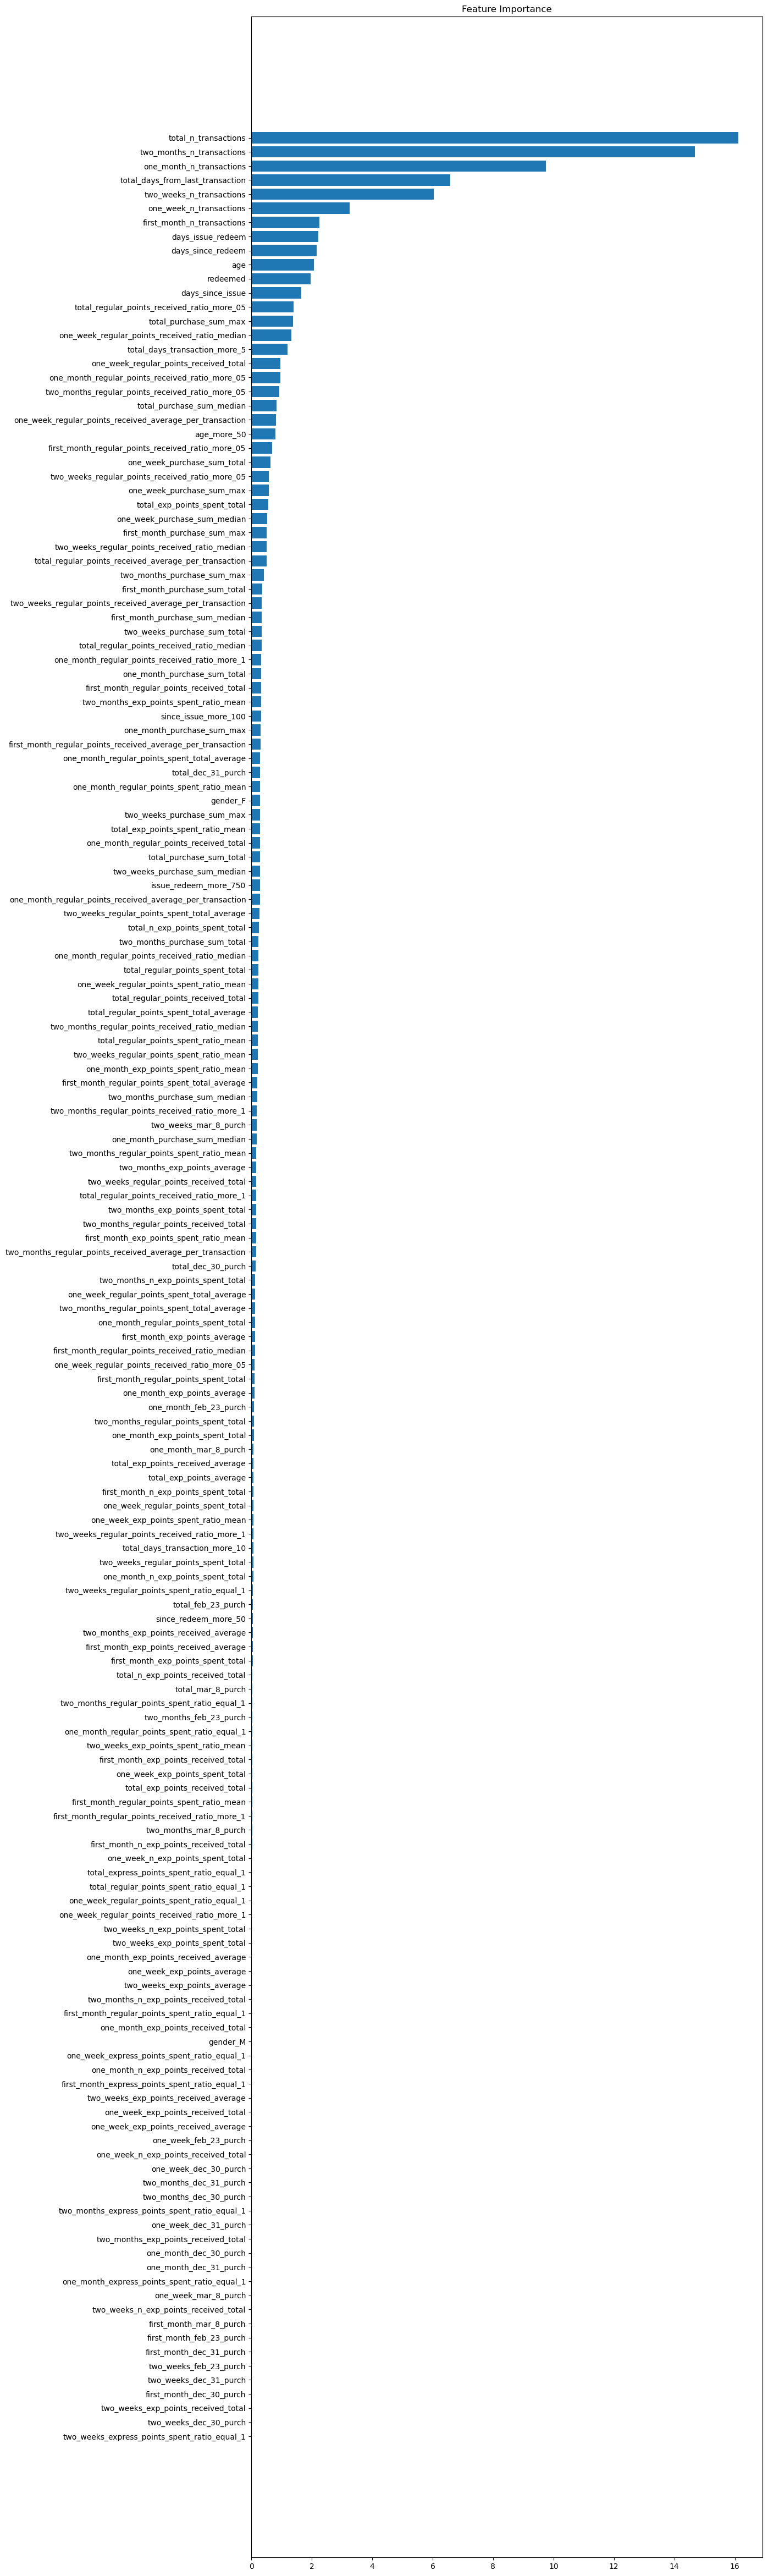

In [38]:
feature_importance = model_cat_tm_1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 60))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_tm_treatment_one_features.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

### Catboost (two-model classifier, treatment = 0)

#### CV, Hyperparameters tuning

In [39]:
model_cat_tm_0 = CatBoostClassifier(
    iterations=5000,
    loss_function ='Logloss',
    eval_metric = 'AUC',
    learning_rate = 0.03,
    random_seed = 1,
    od_type = "Iter",
    od_wait = 200,
    depth = 5,
    #task_type = "GPU",
    #devices = '0:1'
)

In [40]:
cv_params_tm_0 = model_cat_tm_0.get_params()
cv_data_tm_0 = cv(
    Pool(train_tm_treatment_zero_features, train_tm_treatment_zero_target),
    cv_params_tm_0,
    plot=True,
    verbose=100,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	test: 0.7523893	best: 0.7523893 (0)	total: 62.5ms	remaining: 5m 12s
100:	test: 0.7780305	best: 0.7780305 (100)	total: 4.41s	remaining: 3m 33s
200:	test: 0.7792776	best: 0.7792776 (200)	total: 8.44s	remaining: 3m 21s
300:	test: 0.7795989	best: 0.7796056 (299)	total: 12.4s	remaining: 3m 13s
400:	test: 0.7797926	best: 0.7798130 (385)	total: 16.4s	remaining: 3m 8s
500:	test: 0.7798631	best: 0.7799093 (471)	total: 20.7s	remaining: 3m 5s
600:	test: 0.7797894	best: 0.7799093 (471)	total: 24.9s	remaining: 3m 2s

bestTest = 0.7799093166
bestIteration = 471

Training on fold [1/3]
0:	test: 0.7607845	best: 0.7607845 (0)	total: 42.9ms	remaining: 3m 34s
100:	test: 0.7806763	best: 0.7806763 (100)	total: 4.46s	remaining: 3m 36s
200:	test: 0.7818373	best: 0.7818373 (200)	total: 8.64s	remaining: 3m 26s
300:	test: 0.7822008	best: 0.7822200 (295)	total: 12.6s	remaining: 3m 17s
400:	test: 0.7824377	best: 0.7824377 (400)	total: 16.7s	remaining: 3m 11s
500:	test: 0.7825708	best: 0.

In [41]:
best_catboost_score(cv_data_tm_0, cv_params_tm_0)

Best validation score Logloss: 0.54681±0.00214 on step 621
Best validation score AUC: 0.78040±0.00201 on step 483
{'iterations': 5000, 'learning_rate': 0.03, 'depth': 5, 'loss_function': 'Logloss', 'od_wait': 200, 'od_type': 'Iter', 'random_seed': 1, 'eval_metric': 'AUC'}


#### Fit

In [104]:
model_cat_tm_0 = CatBoostClassifier(
    iterations=100,
    loss_function ='Logloss',
    eval_metric = 'AUC',
    learning_rate = 0.03,
    random_seed = 1,
    od_type = "Iter",
    od_wait = 200,
    depth = 5,
    #task_type = "GPU",
    #devices = '0:1'
)

model_cat_tm_0.fit(
    train_tm_treatment_zero_features, train_tm_treatment_zero_target,
    verbose=1000,
);

0:	total: 34.8ms	remaining: 3.45s
99:	total: 3.58s	remaining: 0us


#### Feature importance

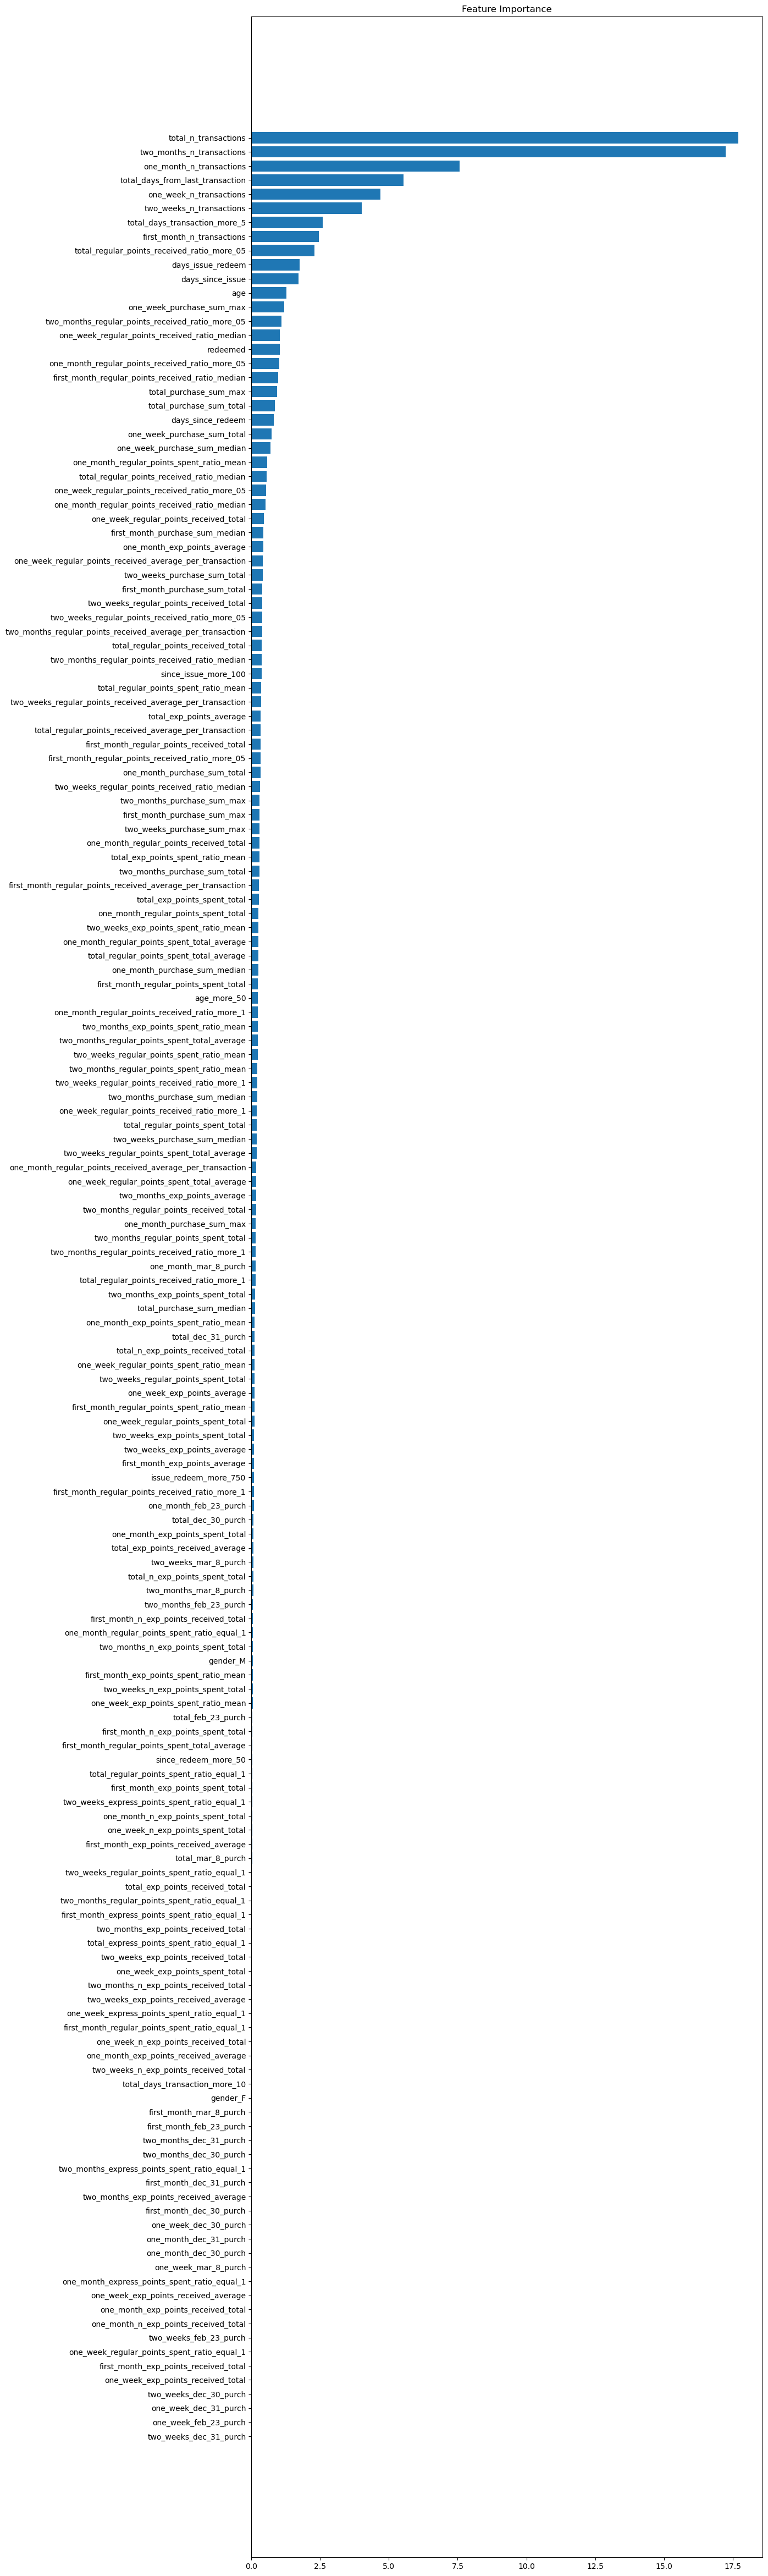

In [50]:
feature_importance = model_cat_tm_0.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 60))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_tm_treatment_one_features.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

#### Predict

In [106]:
tm_0_predict = model_cat_tm_0.predict_proba(train_features)
tm_1_predict = model_cat_tm_1.predict_proba(train_features)
(tm_1_predict[:,1] - tm_0_predict[:,1]).sum() / len(tm_1_predict)

0.03110858033022316

* 3.11% result is close to the mean estimation of the uplift effect

In [109]:
def uplift(df):
    return df.loc[df['treatment_flg']==1, 'purchased'].mean() - df.loc[df['treatment_flg']==0, 'purchased'].mean()

In [110]:
uplift(train)

0.03354516795221374

#### ROC-AUC

In [111]:
roc_auc_score(train['target'].values, tm_1_predict[:,1] - tm_0_predict[:,1])

0.5239285810776491

* Estimated ROC-AUC on fullt train is .56

### Predicting as differences in probas

In [112]:
tm_0_predict_test = model_cat_tm_0.predict_proba(test_features)
tm_1_predict_test = model_cat_tm_1.predict_proba(test_features)
tm_predictions = pd.DataFrame((tm_1_predict_test[:,1] - tm_0_predict_test[:,1]), index=test_features.index, columns=['pred'])

In [113]:
tm_predictions.sum() / tm_predictions.shape[0]

pred    0.031005
dtype: float64

* Predicted uplift effect on the test set is about 3.13% which makes sense as it is what we get on our train set

#### Saving the result

In [114]:
tm_predictions.to_csv('predictions_tm_uplift_MM.csv')

# Summary


* We identified some of the patterns in the loyalty programm data, such as different ratio of points being given on different dates (holidays)
* Two-model predictions gives a better understanding which of the clients are much likely to purchase under the treatment
* Two-model approach helped us to calculate the uplift effect on the train data which we estimated around 3.16%, which is quite close to the difference of the means approach which gives 3.35%
* Overall the forecasting a random variable is an unforgiven job, however we added some extra features based on the loyalty programs data which has helped us to achieve results slightly better than random results (on test dataset around 3% better)